In [2]:
import re, os
import pandas as pd
import pypsa
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [15]:
path = '../results/baltics/summaries'
summaries = [path+"/"+f for f in os.listdir(path)]

In [16]:
path = '../results/germany/summaries'
summaries = summaries + [path+"/"+f for f in os.listdir(path)]

In [33]:
name = summaries[0].split('/')
name = "/".join([name[2], name[-1][:-4]])

In [68]:
df = None

for scenario in summaries:
    series = pd.read_csv(scenario, header=None, index_col=0).squeeze()
    name = scenario.split('/')
    series.name = "/".join([name[2], name[-1][:-4]])
    if df is None:
        df = pd.DataFrame(series)
    else:
        df = df.join(series)

df = df.T

In [69]:
dtypelist = [np.int, np.int, np.int, np.float, 
             np.int, np.int, np.int, np.int,
             np.int, np.int ,np.int ,np.int,
             np.int, np.str, np.float, np.float,
             np.float, np.float, np.float,
             np.float, np.float, np.float,
             np.float, np.int, np.int, np.int,
             np.float, np.str, np.float, np.int,
             np.int, np.float, np.int, np.float,
             np.float, np.float, np.float,
             np.float, np.float, np.float, np.float, np.float]
dtypes = dict(zip(df.columns, dtypelist))
df = df.astype(dtypes)

In [70]:
df['region'] = df.apply(lambda x: x.name.split("/")[0], axis=1)

In [71]:
df['type'] = df.apply(lambda x: x.name.split("_")[-2][1:], axis=1)

In [102]:
d = df
d.loc[d.N==179, 'N'] = 180 # correction
g = d.set_index(['N','T','target_gap','pot_circuits', 'region','type']).groupby('formulation')
kirchhoff = g.get_group('kirchhoff')
angles = g.get_group('angles')
intersection = angles.index.intersection(kirchhoff.index)
kirchhoff = kirchhoff.loc[intersection]
angles = angles.loc[intersection]

In [304]:
d.to_csv("tep-cycle-lopf-results.csv")

In [251]:
comp = pd.concat([kirchhoff['solving 0'], angles['solving 0']], axis=1)
comp.columns = ['kirchhoff', 'angles']
comp = comp.loc[(comp.kirchhoff<39000) | (comp.angles<39000) &
               (comp.kirchhoff>100) & (comp.angles>100)]
comp_div = comp.angles/comp.kirchhoff

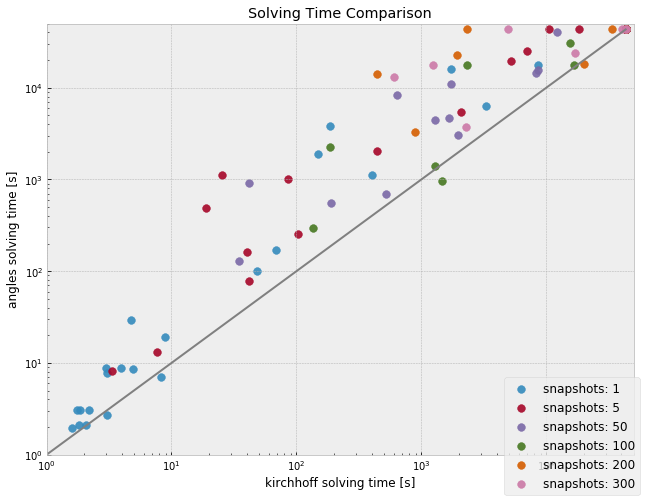

In [295]:
log=True
fig, ax = plt.subplots(1,1,figsize=(9,7))
for gk, ga in zip(kirchhoff.groupby('T'), angles.groupby('T')):
    plt.scatter(gk[1]['solving 0'], ga[1]['solving 0'], s=60,alpha=0.9, label="snapshots: {}".format(gk[0]))
plt.plot(np.linspace(0,43200), np.linspace(0,43200), c='gray')
ax.set_xlabel('kirchhoff solving time [s]')
ax.set_ylabel('angles solving time [s]')
ax.set_ylim([1,50000])
ax.set_xlim([1,50000])
fig.legend(loc='lower right', fontsize=12)
if log:
    ax.set_yscale('log')
    ax.set_xscale('log')
plt.title("Solving Time Comparison")
plt.tight_layout()
plt.savefig("solving_times_log.png", dpi=300)

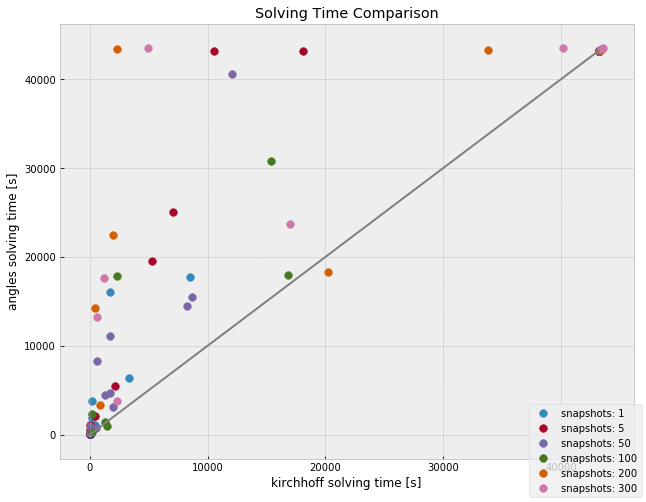

In [294]:
log = False

fig, ax = plt.subplots(1,1,figsize=(9,7))
for gk, ga in zip(kirchhoff.groupby('T'), angles.groupby('T')):
    plt.scatter(gk[1]['solving 0'], ga[1]['solving 0'], s=60,label="snapshots: {}".format(gk[0]))
plt.plot(np.linspace(0,43200), np.linspace(0,43200), c='gray')
ax.set_xlabel('kirchhoff solving time [s]')
ax.set_ylabel('angles solving time [s]')
fig.legend(loc='lower right')
if log:
    ax.set_yscale('log')
    ax.set_xscale('log')
plt.title("Solving Time Comparison")
plt.tight_layout()
plt.savefig("solving_times_lin.png", dpi=300)

In [267]:
(kirchhoff.Constrs / angles.Constrs).mean()

0.9451709969720723

In [266]:
(kirchhoff.Vars / angles.Vars).mean()

0.89635901459618

In [95]:
k_sparsity = kirchhoff.NZs / kirchhoff.Vars / kirchhoff.Constrs
a_sparsity = angles.NZs / angles.Vars / angles.Constrs

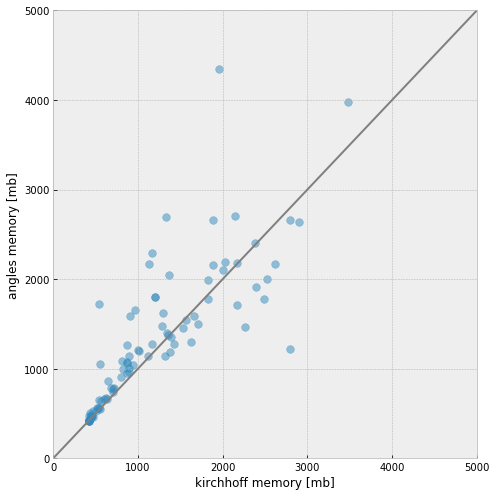

In [296]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.scatter(kirchhoff['peak_mem'], angles['peak_mem'], s=60,alpha=0.5)
plt.plot(np.linspace(0,5000), np.linspace(0,5000), c='gray')
ax.set_xlabel('kirchhoff memory [mb]')
ax.set_ylabel('angles memory [mb]');
ax.set_ylim([0,5000])
ax.set_xlim([0,5000])
plt.tight_layout()
plt.savefig("memory.png", dpi=300)

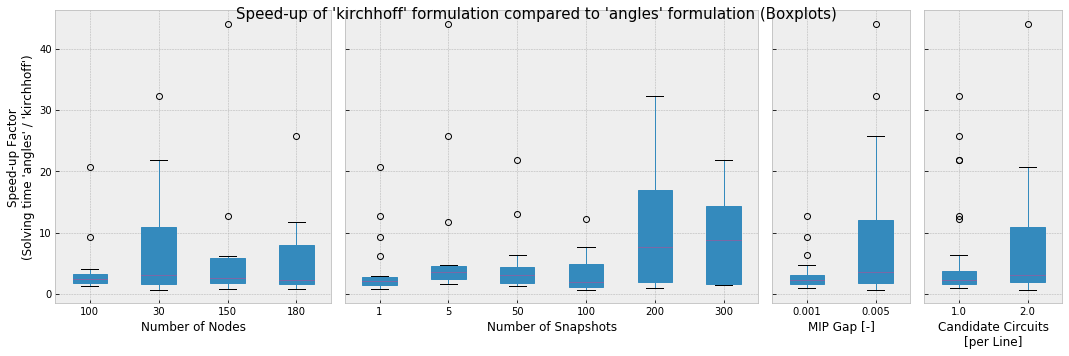

In [289]:
fig, ax = plt.subplots(1,4,figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [4,6,2,2]})
comp_div.unstack('N').plot.box(ax=ax[0], widths=0.5, patch_artist=True)
comp_div.unstack('T').plot.box(ax=ax[1], widths=0.5, patch_artist=True)
comp_div.unstack('target_gap').plot.box(ax=ax[2], widths=0.5, patch_artist=True)
comp_div.unstack('pot_circuits').plot.box(ax=ax[3], widths=0.5, patch_artist=True)

ax[0].set_ylabel("Speed-up Factor\n(Solving time 'angles' / 'kirchhoff')")

ax[0].set_xlabel("Number of Nodes")
ax[1].set_xlabel("Number of Snapshots")
ax[2].set_xlabel("MIP Gap [-]")
ax[3].set_xlabel("Candidate Circuits\n[per Line]")

fig.suptitle("Speed-up of 'kirchhoff' formulation compared to 'angles' formulation (Boxplots)", fontsize=15)
plt.tight_layout()
plt.savefig("speedup_boxplots.png", dpi=300)

In [227]:
kirchhoff.solved_with.value_counts()

barrier         90
dual simplex     2
Name: solved_with, dtype: int64

In [228]:
angles.solved_with.value_counts()

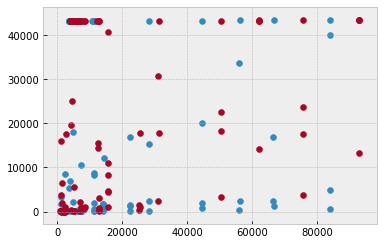

In [352]:
fig, ax = plt.subplots()
ax.scatter(kirchhoff['Vars'], kirchhoff['solving 0'])
ax.scatter(angles['Vars'], angles['solving 0'])
#ax.set_xscale('log')

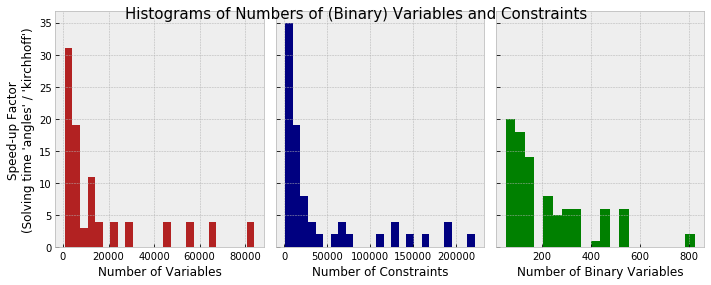

In [288]:
fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True)
kirchhoff.Vars.plot(kind='hist', bins=25, color='firebrick', ax=ax[0])
kirchhoff.Constrs.plot(kind='hist', bins=25, color='navy', ax=ax[1])
angles.IVars.plot.hist(bins=20, color='green', ax=ax[2])

ax[0].set_ylabel("Speed-up Factor\n(Solving time 'angles' / 'kirchhoff')")

ax[0].set_xlabel("Number of Variables")
ax[1].set_xlabel("Number of Constraints")
ax[2].set_xlabel("Number of Binary Variables")

fig.suptitle("Histograms of Numbers of (Binary) Variables and Constraints", fontsize=15)
plt.tight_layout()
plt.savefig("problemsizes.png", dpi=300)

In [298]:
comp_div.mean()

6.12919478959993

In [299]:
comp_div.median()

2.508385263326225

In [301]:
comp_div.loc[comp_div<1]

N    T    target_gap  pot_circuits  region   type
150  1    0.005       2.0           germany  GTEP    0.883347
30   100  0.005       2.0           baltics  GTEP    0.654275
     200  0.001       1.0           baltics  GTEP    0.903682
180  1    0.005       2.0           germany  GTEP    0.846473
dtype: float64

In [312]:
ng = pypsa.Network("../networks/germany/elec_s_180_lcopt_t1_Co2L0.1-1H.nc")

INFO:pypsa.io:Imported network elec_s_180_lcopt_t1_Co2L0.1-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads


In [313]:
nb = pypsa.Network("../networks/baltics/elec_s_180_lcopt_t1_Co2L0.1-1H.nc")

INFO:pypsa.io:Imported network elec_s_180_lcopt_t1_Co2L0.1-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads


In [315]:
ng3 = pypsa.Network("../networks/germany/elec_s_30_lcopt_t100_Co2L0.1-1H.nc")

INFO:pypsa.io:Imported network elec_s_30_lcopt_t100_Co2L0.1-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads


In [317]:
nb3 = pypsa.Network("../networks/baltics/elec_s_30_lcopt_t100_Co2L0.1-1H.nc")

INFO:pypsa.io:Imported network elec_s_30_lcopt_t100_Co2L0.1-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads


In [324]:
ng100 = pypsa.Network("../networks/germany/elec_s_100_lcopt_t1_Co2L0.1-1H.nc")

INFO:pypsa.io:Imported network elec_s_100_lcopt_t1_Co2L0.1-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads


In [325]:
nb100 = pypsa.Network("../networks/baltics/elec_s_100_lcopt_t1_Co2L0.1-1H.nc")

INFO:pypsa.io:Imported network elec_s_100_lcopt_t1_Co2L0.1-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads


/home/ws/sp2668/software/anaconda3/envs/pypsa-eur/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



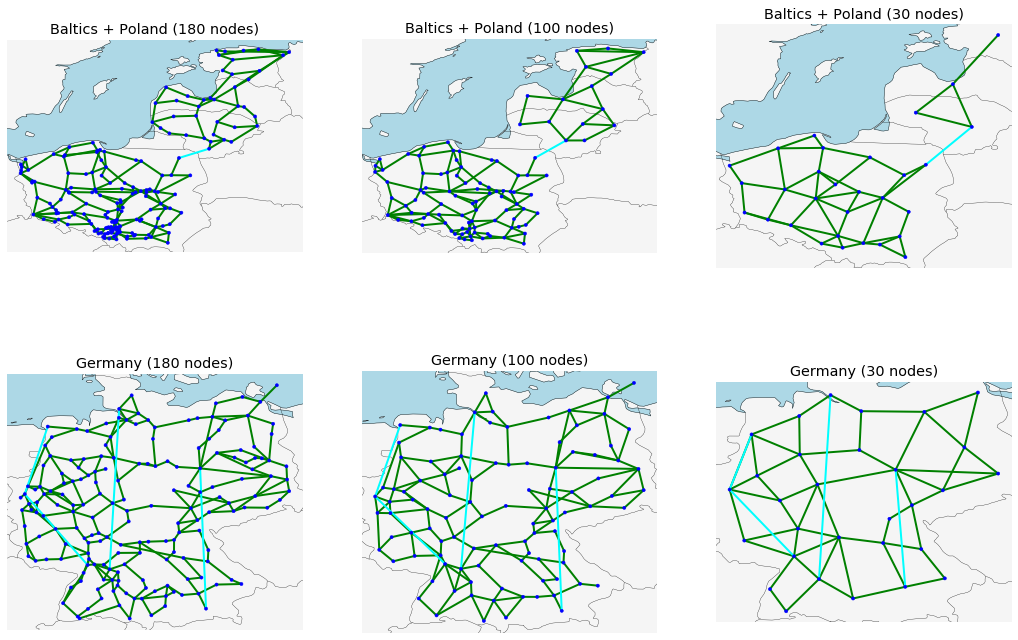

In [335]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(2,3,figsize=(18,12),subplot_kw={"projection":ccrs.PlateCarree()})
nb.plot(ax=ax[0,0], color_geomap=True, title="Baltics + Poland (180 nodes)")
ng.plot(ax=ax[1,0], color_geomap=True, title="Germany (180 nodes)")
nb3.plot(ax=ax[0,2], color_geomap=True, title="Baltics + Poland (30 nodes)")
ng3.plot(ax=ax[1,2], color_geomap=True, title="Germany (30 nodes)")
nb100.plot(ax=ax[0,1], color_geomap=True, title="Baltics + Poland (100 nodes)")
ng100.plot(ax=ax[1,1], color_geomap=True, title="Germany (100 nodes)")
plt.tight_layout()
plt.savefig('maps.png', dpi=300)

In [353]:
ng3.export_to_csv_folder("sample-case")

INFO:pypsa.io:Exported network sample-case has global_constraints, buses, links, generators, carriers, loads, lines
